In [1]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




In [3]:
csv_file = '/content/drive/Shareddrives/CV_videos/preprocessed_270_frames_2_subsampled_unflattened.csv'
THE_data = np.genfromtxt(csv_file, delimiter=',', skip_header=0)

In [4]:
classes, counts = np.unique(THE_data[:, -1], return_counts=True)
classes,counts

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]),
 array([33480, 21870, 34560, 25650, 21600, 24840, 24840, 27270, 30240,
        23220, 24030, 13770, 26730,  9990]))

In [5]:
# Define a custom dataset class -- written by ChatGPT
class MyDataset(Dataset):
    def __check_for_all_zeros(self, i, x):
        if torch.sum(x != 0.0) == 0.0:
            deleting = np.arange(i*self.seq_length, (i+1)*self.seq_length, dtype=np.int64)
            print("DELETING", deleting.shape)
            return deleting
        return None

    def __cleanup_data(self):
        idxs_to_delete = np.zeros(0, dtype=np.int64)
        for i in range(self.__len__()):
          x,y = self.__getitem__(i, init=True)
          # print(x.shape)
          deleting = self.__check_for_all_zeros(i,x)
          if deleting is not None:
            idxs_to_delete = np.concatenate((idxs_to_delete, deleting))

        self.data = np.delete(self.data, idxs_to_delete, axis=0)
        return len(idxs_to_delete)

    def __init__(self, THE_data, seq_length):
        self.seq_length = seq_length
        self.data = THE_data
        self.data[..., :-1] /= self.data[..., :-1].max()
        self.examples = []
        self.labels = np.zeros((0,), dtype=np.int64)
        for index in range(self.__len__()):
            index *= self.seq_length
            self.examples.append(self.data[index:index+self.seq_length, :-1].astype(np.float64))#, dtype=torch.float32)
            self.labels = np.append(self.labels, self.data[index, -1])#, dtype=torch.long)


        self.examples = torch.tensor(np.stack(self.examples), dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        print(self.examples.shape)

        # ret = 1
        # while ret > 0:
        #   ret = self.__cleanup_data()
        #   print("deleted", ret)
        
    def __len__(self):
        return len(self.data) // self.seq_length

    def __getitem__(self, index, init=False):
        x = self.examples[index]
        y = self.labels[index]
        # Return a tuple of input features and target labels
        # index *= self.seq_length
        # x = torch.tensor(self.data[index:index+self.seq_length, :-1], dtype=torch.float32)
        # y = torch.tensor(self.data[index, -1], dtype=torch.long)
        # if not init and self.__check_for_all_zeros(index, x) is not None:
        #   raise Exception("Yup")
        return x, y

    def num_classes(self):
      num_classes = int(np.max(self.data[:, -1]).item()) + 1
      return num_classes

# Define the path to the CSV file
csv_file = '/content/drive/Shareddrives/CV_videos/preprocessed_270_frames_2_subsampled_unflattened.csv'

# Create an instance of the custom dataset class
my_dataset = MyDataset(THE_data, 270)
num_classes = my_dataset.num_classes()
num_classes

torch.Size([1267, 270, 38])


14

In [6]:
# # Define a custom dataset class -- written by ChatGPT
# class MyDataset(Dataset):
#     def __check_for_all_zeros(self, i, x):
#         if torch.sum(x != 0.0) == 0.0:
#             deleting = np.arange(i*self.seq_length, (i+1)*self.seq_length, dtype=np.int64)
#             print("DELETING", deleting.shape)
#             return deleting
#         return None

#     def __cleanup_data(self):
#         idxs_to_delete = np.zeros(0, dtype=np.int64)
#         for i in range(self.__len__()):
#           x,y = self.__getitem__(i, init=True)
#           # print(x.shape)
#           deleting = self.__check_for_all_zeros(i,x)
#           if deleting is not None:
#             idxs_to_delete = np.concatenate((idxs_to_delete, deleting))

#         self.data = np.delete(self.data, idxs_to_delete, axis=0)
#         return len(idxs_to_delete)

#     def __init__(self, csv_file, seq_length):
#         self.seq_length = seq_length
#         self.data = np.genfromtxt(csv_file, delimiter=',', skip_header=0)
#         self.data[..., :-1] /= self.data[..., :-1].max()
#         self.examples = np.zeros((0, 0), dtype=np.float32)
#         self.labels = np.zeros(0, dtype=np.long)
#         for index in range(self.__len__()):
#             index *= self.seq_length
#             self.examples = np.concatenate(self.examples, self.data[index:index+self.seq_length, :-1])#, dtype=torch.float32)
#             self.labels = np.concatenate(self.labels, self.data[index, -1], axis=0)#, dtype=torch.long)
#         print(self.examples.shape)

#         # ret = 1
#         # while ret > 0:
#         #   ret = self.__cleanup_data()
#         #   print("deleted", ret)
        
#     def __len__(self):
#         return len(self.data) // self.seq_length

#     def __getitem__(self, index, init=False):
#         # Return a tuple of input features and target labels
#         index *= self.seq_length
#         x = torch.tensor(self.data[index:index+self.seq_length, :-1], dtype=torch.float32)
#         y = torch.tensor(self.data[index, -1], dtype=torch.long)
#         # if not init and self.__check_for_all_zeros(index, x) is not None:
#         #   raise Exception("Yup")
#         return x, y

#     def num_classes(self):
#       num_classes = int(np.max(self.data[:, -1]).item()) + 1
#       return num_classes

# # Define the path to the CSV file
# csv_file = '/content/drive/Shareddrives/CV_videos/preprocessed_270_frames_2_subsampled_unflattened.csv'

# # Create an instance of the custom dataset class
# my_dataset = MyDataset(csv_file, 270)
# num_classes = my_dataset.num_classes()
# num_classes

In [7]:
train_data, val_data, test_data = torch.utils.data.random_split(my_dataset, [0.7, 0.15, 0.15])
len(train_data), len(val_data), len(test_data)

(887, 190, 190)

In [8]:
# Detect if GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [108]:
batch_size = 64
num_epochs = 150
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=False)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [109]:
def get_src_key_padding_mask(data, device):
  return torch.all(data == 0.0, dim=-1).to(torch.bool).to(device)

In [110]:
import torch.nn.functional as F

class TransformerEncoderWithAttn(nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src

        attn_scores = []
        for layer in self.layers:
            output = layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
            in_proj_weight = layer.self_attn.in_proj_weight
            # print(layer.self_attn.__dict__)
            q, k, v = torch.split(in_proj_weight, [layer.self_attn.embed_dim, layer.self_attn.embed_dim, layer.self_attn.embed_dim])
            attn_scores.append(torch.matmul(q,k.T))
        
        # output = self.norm(output)

        if False:
            output = output.transpose(0, 1)

        return output, torch.stack(attn_scores, dim=0)

In [147]:
## written by ChatGPT
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, num_heads, dropout_prob, output_dim):
        super().__init__()
        # Define the positional encoding layer
        self.positional_encoding = nn.Embedding(seq_len, input_dim)
        self.positions = torch.arange(0, seq_len, device=device).unsqueeze(0)


        # Define the transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(input_dim, num_heads, 4*input_dim, dropout_prob, activation="gelu", batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        # self.transformer_encoder = TransformerEncoderWithAttn(encoder_layer, num_layers)

        # Define the linear output layer
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, inputs, padding_mask):
        # Add positional embeddings to the input
        embeddings = self.positional_encoding(self.positions)

        inputs = inputs + embeddings

        # Pass the inputs through the transformer encoder layer
        outputs = self.transformer_encoder(inputs, src_key_padding_mask=padding_mask)
        # print(outputs)

        # Pass the last hidden state through the linear output layer
        last_hidden_state = outputs[:, -1, :]
        outputs = self.linear(last_hidden_state)

        return outputs, None


In [148]:
loss_function = nn.CrossEntropyLoss()

try:
  model.detach()
  model = None
except: pass
model = TransformerModel(input_dim=38, seq_len=270, num_layers=12, num_heads=2, dropout_prob=0.1, output_dim=num_classes)
model_name = "model2"

In [149]:
params_to_update = model.parameters()

learning_rate = 0.005
reg_lambda = 0.001

# Observe that all parameters are being optimized
optimizer_ffn = optim.AdamW(params_to_update, lr=learning_rate)
scheduler_ffn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ffn, 'min', factor=0.1, patience=10, threshold=0.001)

In [150]:
def calculate_loss(pred, labels, reg_lambda=0.05):
  loss = F.cross_entropy(pred, labels)
  l2_reg = torch.tensor(0.).to(device)
  for param in model.parameters():
    l2_reg += torch.norm(param, p=2)**2 +  torch.norm(param, p=1)
  return reg_lambda*l2_reg + loss

In [151]:
def showAttention(attn):
    # query: (L_q x d_k)
    # key: (L_k x d_k)
    # attn: (L_q x L_k)

    # Normalize attention scores
    attn = attn.cpu().detach().numpy()
    attn = attn / attn.sum(axis=1, keepdims=True)

    # Plot heatmap
    sns.set(font_scale=1.4)
    heatmap = sns.heatmap(attn, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.show()


In [152]:
def train_ffn(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, device: torch.device, silent: bool = True, reg_lambda=0.01):
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 50

    running_loss = 0
    last_loss = 0
    correct = 0 
    total = 0
    
    for i, (data, labels) in enumerate(loader):
        optimizer.zero_grad()
        data = data.to(device)
        mask = get_src_key_padding_mask(data, device)
        labels = labels.to(device)
        pred, attn = model(data, mask)
        # showAttention(attn[3])
        # print(pred)
        loss = calculate_loss(pred, labels, reg_lambda)
        _, predicted = torch.max(pred.data, 1)
        # print(predicted.shape)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
        )
        data.detach()
        labels.detach()


    return np.mean(losses), correct / total

In [153]:
torch.cuda.empty_cache()

In [154]:
best_vloss = np.inf
best_model_wts = dict()

av_loss_per_epoch = []
av_val_loss_per_epoch = []
model.to(device)
print(model)
model_path = "best_model_so_far"

for i in range(num_epochs):
    print('EPOCH {}:'.format(i + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss, accuracy = train_ffn(model, trainloader, optimizer_ffn, device, reg_lambda=reg_lambda)

    # We don't need gradients on to do reporting
    model.eval()

    running_vloss = 0.0
    iter = 0
    correct_val_data = 0
    total_val_data = 0
    with torch.no_grad():
        for j, vdata in enumerate(valloader):
            val_inputs, val_labels = vdata
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_mask = get_src_key_padding_mask(val_inputs, device)
            val_pred, attn = model(val_inputs, val_mask)
            
            vloss = calculate_loss(val_pred, val_labels, reg_lambda)
            validation_loss = vloss.item()
            running_vloss = running_vloss + vloss
            iter += 1
            _, v_predicted = torch.max(val_pred.data, 1)
            correct_val_data += (v_predicted == val_labels).sum().item()
            total_val_data += val_labels.size(0)
            val_inputs.detach()
            val_labels.detach()

    avg_vloss = running_vloss / (iter + 1)
    av_loss_per_epoch.append(avg_vloss)

    print('Loss: train {} valid {} learning_rate {}'.format(avg_loss, avg_vloss, optimizer_ffn.param_groups[0].get('lr')))
    print('Accuracy: train {} valid {}'.format(accuracy, correct_val_data / total_val_data))

    scheduler_ffn.step(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), model_path)

    if torch.cuda.is_available():
      torch.cuda.empty_cache()

TransformerModel(
  (positional_encoding): Embedding(270, 38)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=38, out_features=38, bias=True)
        )
        (linear1): Linear(in_features=38, out_features=152, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=152, out_features=38, bias=True)
        (norm1): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=38, out_features=14, bias=True)
)
EPOCH 1:
Loss: train 34.225673811776296 valid 21.327579498291016 learning_rate 0.005
Accuracy: train 0.08680947012401354 valid 0.07368421052631578
EPOCH 2:
Loss

In [155]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [156]:
import os 
import datetime
trained_model_name = str(model_name) + "_b" + str(batch_size) + "_ep" + str(num_epochs) + "_lr" + str(learning_rate) + "_scheduling"
FOLDER_NAME = "drive/Shareddrives/CV_videos/results_training_NN/Transformer/" + trained_model_name

if os.path.isdir(FOLDER_NAME):
  FOLDER_NAME = "drive/Shareddrives/CV_videos/results_training_NN/Transformer/" + trained_model_name + "_" + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
os.mkdir(FOLDER_NAME)

In [157]:
PATH_TO_SAVE_CLREPORT = FOLDER_NAME + "/classification_report.csv"
PATH_TO_SAVE_VALACCURACY = FOLDER_NAME + "/validation_accuracy_per_epoch.csv"
PATH_TO_SAVE_TESTACC = FOLDER_NAME + "/final_test_accuracy.csv"
PATH_TO_SAVE_CONFUSION = FOLDER_NAME + "/confusion_matrix.csv"

Test set: Average loss: 2.6042, Accuracy: 18/190 (9.47%)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(2.6042186511190315, 0.09473684210526316)

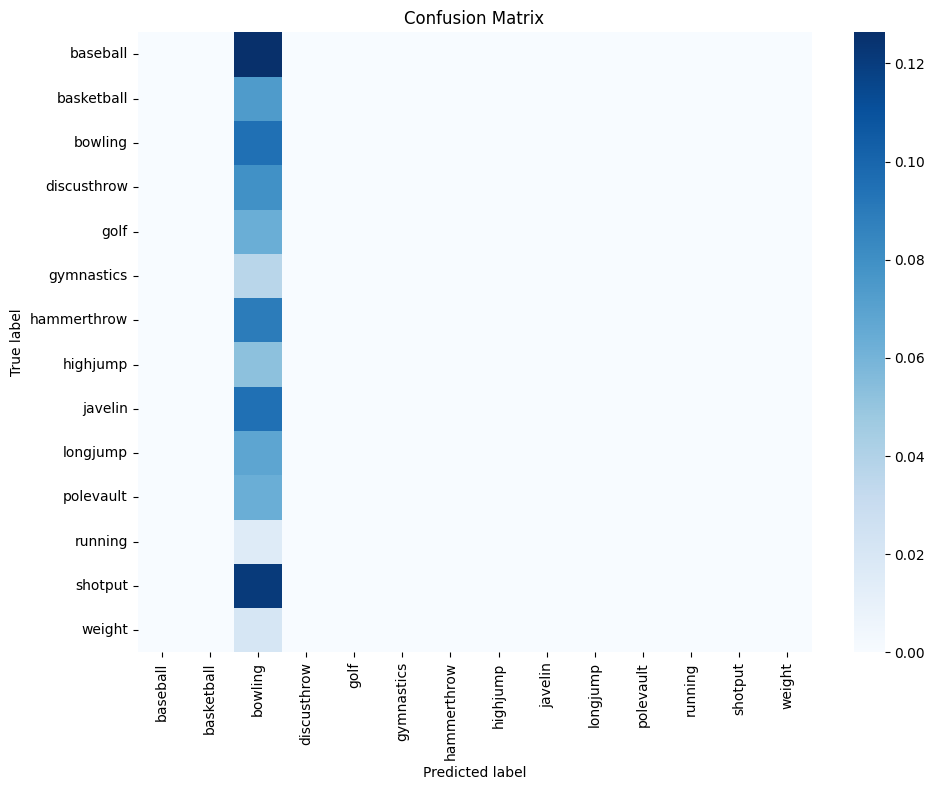

In [158]:
def evaluate(model, dataloader, loss_fn, device, best_so_far=False):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables for tracking the loss and accuracy
    total_loss = 0
    correct = 0
    total = 0
    
    all_pred = []
    all_true = []

    # Disable gradient computations for efficiency
    with torch.no_grad():
        # Loop through the data in the dataloader
        for batch_idx, (data, target) in enumerate(dataloader):
            # Move the data and target tensors to the device
            data, target = data.to(device), target.to(device)
            # print("data", data)
            
            # Forward pass the data through the model
            mask = get_src_key_padding_mask(data, device)
            output, attn = model(data, mask)
            # print("output", output)
            # Compute the loss between the model's predictions and the target
            loss = loss_fn(output, target)
            
            # Update the total loss
            total_loss += loss.item() * target.size(0)
            
            # Compute the accuracy of the model's predictions
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            data.detach()
            # target.detach()

            all_pred.append(predicted)
            all_true.append(target)
            
    
    # Compute the average loss and accuracy over the entire dataset
    avg_loss = total_loss / total
    accuracy = correct / total
    
    y_all_pred = torch.cat(all_pred).cpu().numpy()
    y_all_true = torch.cat(all_true).cpu().numpy()

    # print(np.unique(y_all_true))
    # all_pred = [a.cpu().numpy().tolist() for a in all_pred]
    # all_true = [a.cpu().numpy().tolist() for a in all_true]
    # print(y_all_pred)
    # print(y_all_true)

    class_labels = ['baseball', 'basketball', 'bowling', 'discusthrow', 'golf', 'gymnastics', 'hammerthrow', 'highjump', 'javelin', 'longjump', 'polevault', 'running', 'shotput', 'weight']
    # class_labels = None
    cm = confusion_matrix(y_true=y_all_true, y_pred=y_all_pred, normalize='all', labels=None)
    save_confusion_path = PATH_TO_SAVE_CONFUSION
    if best_so_far:
      save_confusion_path = save_confusion_path.replace(".csv", "_best_so_far.csv")
    np.savetxt(PATH_TO_SAVE_CONFUSION, cm, delimiter=",")

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='.3f', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()

    # Save the plot to a file
    fig.savefig(PATH_TO_SAVE_CONFUSION + ".png")

    clsf_report = pd.DataFrame(classification_report(y_true = y_all_true, y_pred = y_all_pred, output_dict=True, target_names=class_labels)).transpose()
    save_clreport_path = PATH_TO_SAVE_CLREPORT
    if best_so_far:
      save_clreport_path = save_clreport_path.replace(".csv", "_best_so_far.csv")
    clsf_report.to_csv(save_clreport_path, index= True)
    

    # Print the results
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct, total, 100. * accuracy))
    
    return avg_loss, accuracy


avg_loss, accuracy = evaluate(model, testloader, F.cross_entropy, device)
avg_loss, accuracy



Test set: Average loss: 2.6042, Accuracy: 18/190 (9.47%)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(2.604197697890432, 0.09473684210526316)

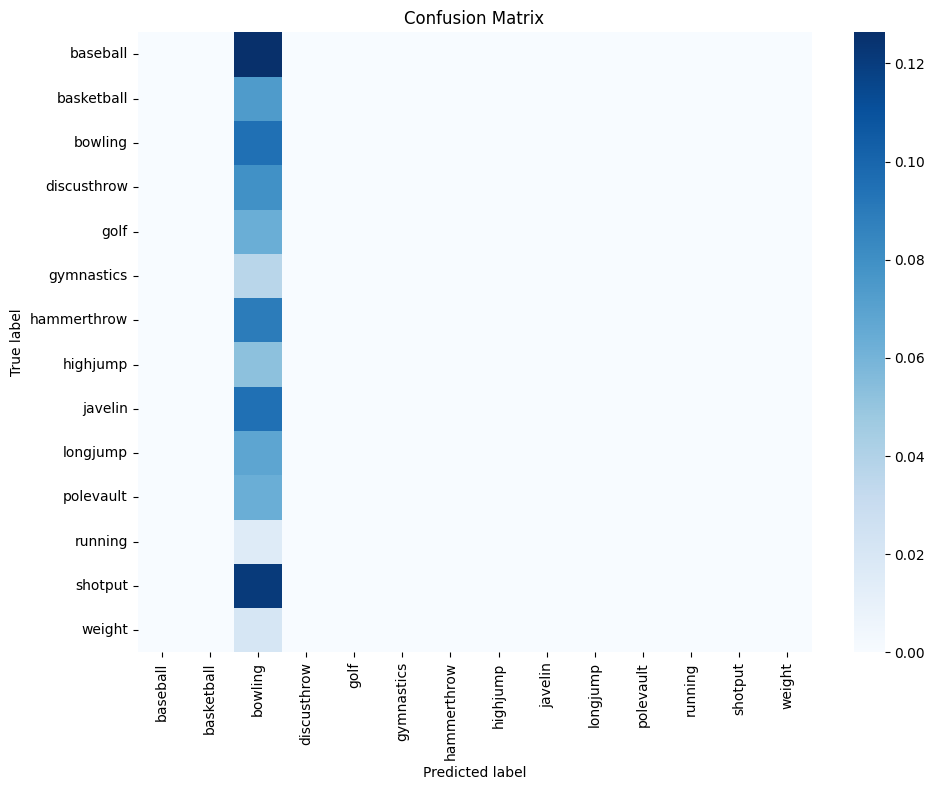

In [159]:
model_path = "best_model_so_far"

best_model_wts = torch.load(model_path)
model.load_state_dict(best_model_wts)
model.to(device)
avg_loss, accuracy = evaluate(model, testloader, F.cross_entropy, device, best_so_far=True)
avg_loss, accuracy